# Big Data - Pyspark application

Membres du groupe :

| Noms             | UID   | Mail                      |
|------------------|-------|---------------------------|
| Adrien Merat     | 23745 | adrien.merat@epita.fr     |
| Mehdi Oueslati   | 23550 | mehdi.oueslati@epita.fr   |
| Emmanuel Mollard | 23082 | emmanuel.mollard@epita.fr |

## Exploration des données

### 1. Importation des librairies

In [28]:
from pyspark.ml.linalg import DenseMatrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import TimestampType, DoubleType, StringType, \
    StructField, StructType
from pyspark.sql.functions import isnan, when, count, datediff, mean, lag, \
    col, month, year, weekofyear, date_format, dayofmonth
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

### 2. Création de la session Spark

In [29]:
def create_spark_session(name: str) -> SparkSession:
    """
    Create a spark session using the <name>
    """
    return SparkSession.builder.appName(name).getOrCreate()

### 3. Importation des données

In [30]:
def load_data(spark_session: SparkSession, path: str) -> DataFrame:
    """
    Create spark dataframe from the csv file at <path>
    """
    dev_schema = StructType([
        StructField("Date", TimestampType()),
        StructField("High", DoubleType()),
        StructField("Low", DoubleType()),
        StructField("Open", DoubleType()),
        StructField("Close", DoubleType()),
        StructField("Volume", DoubleType()),
        StructField("Adj Close", DoubleType()),
        StructField("company_name", StringType()),
    ])
    return spark_session.read.csv(path, dev_schema, header=True)

### 4. Exploration des données

#### 4.1. Comptage des valeurs manquantes

In [31]:
def count_nan(data_frame: DataFrame) -> DataFrame:
    """
    Count nan in the <df> DataFrame
    """
    return data_frame.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c)
        for c
        in ["High", "Low", "Open", "Close", "Volume", "Adj Close"]
    ])

#### 4.2. Durée moyenne entre deux relevés

On constate que les relevés sont fait tous les jours ouvrables, c'est-à-dire du lundi au vendredi. Il y a donc des trous causés par les weekends. Pour calculer la durée moyenne entre deux relevés, on utilise la fonction `datediff` qui calcule la différence entre deux dates. On fait cela pour chaque ligne en la comparant à la suivante, puis on fait une moyenne. On trouve une durée moyenne de 1,45 jours.

In [32]:
def duration_between_rows(data_frame: DataFrame):
    """
    Calculate the mean duration between each rows
    """
    data_frame = data_frame.orderBy('Date')
    data_frame = data_frame.withColumn('duration',
                                       datediff(data_frame['Date'],
                                                lag(data_frame['Date'], 1).over(
                                                    Window.partitionBy("company_name").orderBy('Date')))
                                       )
    return data_frame.select(mean('duration')).collect()[0][0]

#### 4.3. Matrice de corrélation

In [33]:
def corr_matrix(data_frame: DataFrame) -> DenseMatrix:
    """
    Return the correlation matrix of a dataframe
    """

    vector_col = "corr_features"
    assembler = VectorAssembler(
        inputCols=["High", "Low", "Open", "Close", "Volume", "Adj Close"],
        outputCol=vector_col
    )
    df_vector = assembler.transform(data_frame).select(vector_col)

    matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

    return matrix

On propose ci-dessous une fonction pour ajouter une visualisation graphique de la matrice de corrélation.

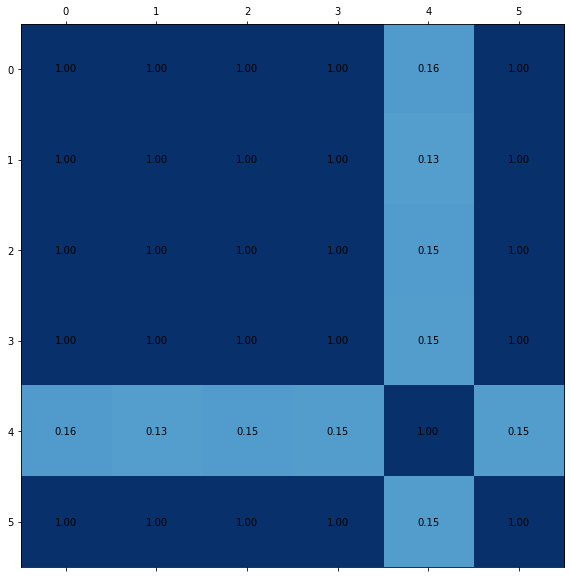

In [34]:
def plot_corr_matrix(matrix):
    """
    Plot the correlation matrix
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(matrix, cmap=plt.cm.Blues, vmin=-1, vmax=1)
    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.show()

plot_corr_matrix(corr_matrix(load_data(create_spark_session("corr"), "stocks_data/AMAZON.csv")).toArray())

On écrit ci-dessous une fonction permettant de calculer la matrice de corrélation entre deux dataframes, afin de comparer deux compagnies.

In [35]:
def correlate_two_dataframe(
        df1:DataFrame,
        df2:DataFrame,
        col_in_df1:str,
        col_in_df2:str = None) -> float:
    """
    by default, col_in_df2 is equal to col_in_df1
    """
    if col_in_df2 is None:
        col_in_df2 = col_in_df1
    if col_in_df1 == col_in_df2:
        col_in_df2 = f'{col_in_df1}_2'
        df2 = df2.withColumnRenamed(col_in_df1, col_in_df2)

    df = df1.join(df2, 'Date', 'inner').select(col_in_df1, col_in_df2)
    return df.stat.corr(col_in_df1, col_in_df2)

#### 4.4 Description de la dataframe

In [36]:
def describe_data_frame(data_frame: DataFrame):
    """
    Describe the dataframe
    - print the first and last 40 lines
    - print the number of observations
    - print the period between the data points
    - print the min, max, mean and standard deviation
    - print the number of missing values for each dataframe and column
    - print correlation matrix
    """
    print("Dataframe schema:")
    data_frame.printSchema()

    print("First 40 lines:")
    data_frame.show(40)

    print(f"Number of observations: {data_frame.count()}\n")

    print("Period between data points:")
    print(duration_between_rows(data_frame))

    # Descriptive statistics for each dataframe and each column (min, max,
    # standard deviation)
    data_frame.describe().show()

    print("Number of missing values for each dataframe and column:")
    count_nan(data_frame).show()

    print("Correlation between 'High' and 'Low':")
    pearson_corr = data_frame.stat.corr('High', 'Low')
    print(pearson_corr)
    print("Correlation matrix:")
    corr = corr_matrix(data_frame)
    print(corr, '\n')

#### 4.5. Moyennes sur une période

In [37]:
def week_mean(data_frame: DataFrame) -> DataFrame:
    """
    Return average of each week for columns Open and Close
    """
    return data_frame.withColumn("Year", year("Date")) \
        .withColumn("Week", weekofyear("Date")) \
        .groupBy("Year", "Week") \
        .avg("Open", "Close") \
        .orderBy(["Year", "Week"])


def month_mean(data_frame: DataFrame) -> DataFrame:
    """
    Return average of each month for columns Open and Close
    """
    return data_frame.withColumn("Year", year("Date")) \
        .withColumn("Month", month("Date")) \
        .groupBy("Year", "Month") \
        .avg("Open", "Close") \
        .orderBy(["Year", "Month"])


def year_mean(data_frame: DataFrame) -> DataFrame:
    """
    Return average of each year for columns Open and Close
    """
    return data_frame.withColumn("Year", year("Date")) \
        .groupBy("Year") \
        .avg("Open", "Close") \
        .orderBy("Year")

#### 4.6. Variation jour par jour

In [38]:
def change_day_to_day(df: DataFrame, col: str) -> DataFrame:
    """
    Add new column with comparaison between previous and next row value in column col
    """
    df = df.orderBy('Date')
    return df.withColumn(col + "_change",
                         lag(df[col], 1).over(Window.partitionBy("company_name").orderBy('Date')) - df[col]
                         )

#### 4.7. Graphique

On propose un graphique en bougies pour diverses échelles temporelles (jour, mois, année).

In [39]:
def candle_sticks(data, Month: int, Year: int, saveoption: bool = None):
    """
    data : pyspark dataframe
    month : number related to the focus month
    year : number related to the focus year
    saveoption : save the figure into a file "month_year.png"
    """
    data = data.withColumn('monthandday', date_format(data.Date, "d MMM"))
    data = data.withColumn('day', dayofmonth(data.Date))
    data = data.withColumn('month', month(data.Date))
    data = data.withColumn('year', year(data.Date))

    data = data.filter(data.month == Month).filter(data.year == Year)
    pd_am = data.toPandas()
    pd_am.index = pd_am.Date
    pd_am = pd_am.drop(columns="Date")
    up = pd_am[pd_am.Close >= pd_am.Open]
    down = pd_am[pd_am.Close < pd_am.Open]

    heigh = 0.1
    width = 0.5

    plt.figure(figsize=(9, 7))
    plt.title("CandleStick Chart")

    plt.bar(up.monthandday, up.Close - up.Open, width, bottom=up.Open, color='green')
    plt.bar(up.monthandday, up.High - up.Close, heigh, bottom=up.Close, color='green')
    plt.bar(up.monthandday, up.Low - up.Open, heigh, bottom=up.Open, color='green')

    plt.bar(down.monthandday, down.Close - down.Open, width, bottom=down.Open, color='red')
    plt.bar(down.monthandday, down.High - down.Open, heigh, bottom=down.Open, color='red')
    plt.bar(down.monthandday, down.Low - down.Close, heigh, bottom=down.Close, color='red')

    plt.xticks(rotation=45, ha='right')
    plt.legend(["green", "red"])
    if saveoption:
        sgd = str(Month) + '_' + str(Year)
        plt.savefig(sgd)
    plt.show()

### 5. Fonction `main()`

La fonction ci-dessous appelle les fonctions précédentes pour réaliser les graphiques et calculer les valeurs demandées.

In [40]:
def main():
    spark = create_spark_session("Spark_Application_Name")
    dfs = []
    for f in ['AMAZON.csv', 'APPLE.csv', 'FACEBOOK.csv', 'GOOGLE.csv',
              'MICROSOFT.csv', 'TESLA.csv', 'ZOOM.csv']:
        print(f"\n{f}:")
        df = load_data(spark, 'stocks_data/' + f)
        # describe_data_frame(df)

        week_mean(df).show()
        month_mean(df).show()
        year_mean(df).show()

        dfs.append(df)

        df = change_day_to_day(df, 'Open')
        df = change_day_to_day(df, 'Close')

In [41]:
main()


AMAZON.csv:
+----+----+-----------------+-----------------+
|Year|Week|        avg(Open)|       avg(Close)|
+----+----+-----------------+-----------------+
|2017|   1|765.0549926757812|771.8224945068359|
|2017|   2|800.5779907226563|804.5240112304688|
|2017|   3|812.6200103759766|808.6424865722656|
|2017|   4|825.8239990234375|830.3520141601563|
|2017|   5|  825.85400390625|827.2719970703125|
|2017|   6| 815.443994140625|817.7340087890625|
|2017|   7|837.2920043945312|    840.966015625|
|2017|   8|852.0125122070312|852.3699951171875|
|2017|   9|849.4320068359375|849.1099975585937|
|2017|  10|   849.3419921875|849.7180053710938|
|2017|  11|853.6880004882812|853.1640014648438|
|2017|  12|850.1320068359375| 848.243994140625|
|2017|  13|860.1640014648438|  868.00400390625|
|2017|  14|  900.75400390625|900.1560180664062|
|2017|  15|900.3025054931641|897.5749816894531|
|2017|  16|899.7400024414062|  901.11201171875|
|2017|  17| 917.847998046875|  913.53798828125|
|2017|  18|941.144006347656